# Классификация возраста, пола и расы по лицу человека

Используйте публичные данные UTKfaces. https://susanqq.github.io/UTKFace/
В работе необходимо использовать данные Aligned&Cropped Faces, где произведены вырезы лиц с исходных изображений.

Изображения хранятся в формате jpg. В имени (почти!!!) каждого иображения имеется информации о человеке

$$[возраст]\_[пол]\_[раса]\_[время].jpg$$

Потребуются первые три параметра из названия каждого файлы.

В текущем файле реализована тренировка сверточной нейронной сети resnet50 для классификации возраста по фотографии. Текущая СНС используется с предобученными весами (transfer learning - перенос обучения) на датасете imagenet. Перенос обучения позволяет использовать веса сети с другого набора данных. Как правило, такой подход позволяет существенно поднять точность предсказания на новом наборе данных.

Задачи:
1. Переписать класс Dataset так, чтобы __getitem__ выдывал классы возраст, пол и раса. Задача регрессии для предсказания возраста является сложно, в этой связи будем решать ее как классификационную. Необходимо закодировать возраст в один из классов [(0, 5), (5, 14), (14, 30), (30, 45), (45, 60), (60, 120)], таким образом __getitem__ будет выдавать номер класса, которому принадлежит человек на фотографии.
Дополнительная задача (по желанию): при классификации ответом является возрастная, а не число. Можно получать возраст в числом выражении если использовать математическое ожидание по ответам нейронной сети. Для этого необходимо умножить ответы в виде Softmax на средние значения возраста в каждой группе и проссумировать все значения. 

2. Переписать класс Net. Добавить Mobilentv2 и Resnet34, так чтобы аргументом net можно было выбрать на основе какого экстрактора признаков построить сеть для классификации. Добавить дополнительные классификаторы для возраста и расы.

3. Обучить сеть. Попробуйте оптимизатор SGD и Adam. Визуализировать результаты на валидационном наборе данных.

Примечание: для тренировки лучше использовать GPU или colab.research.google.com с поддержкой GPU.

In [1]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Ниже реализован класс Dataset, который имеет три обязательных метода __init__, __len__, __getitem__.

- __init__ происходит инициализация переменных датасета.
- __len__ возращает количество изображений в датасете.
- __getitem__ возвращает изображение в формате PIL и значения классов age, gender, race по индексу.

Размер изображения установить $224 \times 224$. В случае медленного обучения на процессоре параметр можно уменьшить, но потребуется произвести изменения в месте крепления экстрактора признаков и классификатора нейронной сети.

In [2]:
import torch
from torch.utils import data

T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, path, subset = 'train', test_part = 0.2, transform = None):
        'Initialization'
        self.path = path
        self.subset = subset
        self.transform = transform
        names = [it for it in os.listdir(path) if len(it.split('_')) > 3]
        
        names = [os.path.join(path, it) for it in names]
        np.random.seed(0)
        np.random.shuffle(names)
        if subset == 'train':
            self.ids = names[:int(len(names) * test_part)]
        elif subset == 'valid':
            self.ids = names[int(len(names) * test_part):]
        self.age_list = [(0, 5), (5,14), (14, 30), (30, 45), (45, 60), (60, 120)]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.ids)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.ids[index]

        image = Image.open(ID)

        # Load data and get label
        gender = int(ID.split('/')[-1].split('_')[1])
        
        if self.transform:
            image = self.transform(image)
        
        return image, gender

In [3]:
path_to_data = '/home/vasily/datasets/UTKFace'
train_data = Dataset(path_to_data, subset='train', test_part = 0.2, transform = T)
valid_data = Dataset(path_to_data, subset='valid', test_part = 0.2, transform = T)

Ниже представлен пример получения изображения по индексу.

0


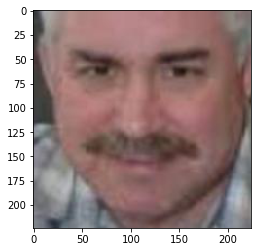

In [4]:
img, gender = train_data[138]
print(gender)
plt.imshow(img.numpy().transpose(1,2,0))

Объекты train_data и valid_data передадим в DataLoader. Объект train_loader и valid_loader будут выдавать пачку изображения с правильными ответами (батчи).

In [5]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=16, 
                                           shuffle=True)

# download and transform test dataset
valid_loader = torch.utils.data.DataLoader(valid_data,
                                          batch_size=16, 
                                          shuffle=False)

tensor([1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1])


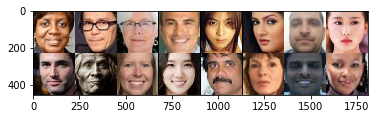

In [6]:
images, gender = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))
print(gender)

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
from torchvision.models import mobilenet_v2, resnet34, resnet50
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, net='mobilenetv2', pretrained=True):
        super(Net, self).__init__()
        self.net = net
        if self.net == 'mobilenetv2':
            self.model = models.mobilenet_v2(pretrained=True)
            # code here
        elif self.net == 'resnet34':
            self.model = models.resnet34(pretrained=True)
            # code here
        elif self.net == 'resnet50':
            self.model = models.resnet50(pretrained=True)

        self.model.gender_cls = nn.Linear(2048, 2)

    def forward(self, x):
        if self.net == 'resnet50':
            x = self.model.conv1(x)
            x = self.model.bn1(x)
            x = self.model.relu(x)
            x = self.model.maxpool(x)
            x = self.model.layer1(x)
            x = self.model.layer2(x)
            x = self.model.layer3(x)
            x = self.model.layer4(x)
            x = self.model.avgpool(x)
            x = x.view(x.size(0), -1)
            gender = self.model.gender_cls(x)

        
        return gender

model = Net(net='resnet50').to(device)

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum = 0.9)

In [ ]:
from IPython.display import clear_output

for epoch in range(10):  # loop over the dataset multiple times

    for phase in ['train', 'valid']:
        
        if phase == 'train':
            
            model.train(True)
            
            running_loss = 0.0
            correct = 0
            total = 0

            gender_correct = 0
            
            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, gender = data[0].to(device), data[1].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                out_gender = model(inputs)

                loss_gender = criterion(out_gender, gender)
                
                loss = loss_gender

                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()

                _, gender_pred = torch.max(out_gender.data, 1)
                
                total += gender.size(0)
                
                gender_correct += (gender_pred == gender).sum().item()
                
                
        elif phase == 'valid':
            
            model.train(False)
            
            validation_loss = 0.
            v_correct = 0
            v_total = 0
            
            v_gender_correct = 0

            for i, v_data in enumerate(valid_loader):
                v_loss = 0
                v_inputs, v_gender = v_data[0].to(device), v_data[1].to(device)

                v_out_gender = model(v_inputs)

                v_loss += criterion(v_out_gender, v_gender)

                validation_loss += v_loss.item()

                _, v_gender_pred = torch.max(v_out_gender.data, 1)

                v_total += v_gender.size(0)

                v_gender_correct += (v_gender_pred == v_gender).sum().item()

    print('Epoch %d, loss: %.3f, val_loss: %.3f, acc_gender: %.3f, val_acc_gender: %.3f' %
          (epoch + 1, running_loss / len(train_loader), validation_loss / len(valid_loader), 
           gender_correct / total, v_gender_correct / v_total,))           

print('Finished Training')

Epoch 1, loss: 0.671, val_loss: 0.654, acc_gender: 0.603, val_acc_gender: 0.646
Epoch 2, loss: 0.643, val_loss: 0.625, acc_gender: 0.674, val_acc_gender: 0.699
Epoch 3, loss: 0.614, val_loss: 0.602, acc_gender: 0.719, val_acc_gender: 0.722
Epoch 4, loss: 0.591, val_loss: 0.577, acc_gender: 0.740, val_acc_gender: 0.747
Epoch 5, loss: 0.568, val_loss: 0.555, acc_gender: 0.762, val_acc_gender: 0.761
Epoch 6, loss: 0.547, val_loss: 0.534, acc_gender: 0.771, val_acc_gender: 0.778
